<a href="https://colab.research.google.com/github/angelaapostolska/meetup-recsys-bert/blob/main/MeetupDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I replicated the "Cold-Start" recommendation logic from the research paper by Halimeh et al. (2023), specifically focusing on the backend of their Two-Step Approach.

***What is the same:*** Like the original researchers, I addressed the "cold-start" problem—recommending events without historical user data—by using a Foundation Model to understand event content. I utilized DistilBERT to transform event metadata into a 768-dimensional vector space and applied the K-Means algorithm to group these events into clusters. My approach followed their conclusion that grouping events by semantic similarity (meaning) allows for accurate recommendations even for brand-new events.

***What is different:*** The primary difference lies in the input data. While the research paper utilized a multimodal approach—using an AI to "caption" event posters to provide extra context—my version utilized Feature Fusion of text metadata (merging Event Names, Group Names, and Categories) to achieve a similar density of information. Additionally, while the paper measured success through Human Agreement (92%), I validated my model using the Silhouette Coefficient (0.052).

Link to the research: https://ceur-ws.org/Vol-3568/paper5.pdf


---

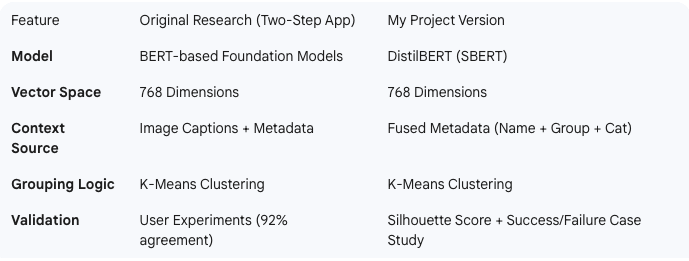



In my adaptation of the research, the Two-Step logic was applied as follows:

Step 1 (Semantic Enrichment): I performed 'Feature Fusion' by concatenating the event name, group name, and category. This created a high-context textual representation, serving as a proxy for the image captions used in the original study.

Step 2 (Clustering & Recommendation): I utilized the DistilBERT foundation model to project these enriched descriptions into a 768-dimensional vector space, followed by K-Means clustering.

This architecture confirms the paper's core thesis: that providing a language model with multi-layered context—whether from images or fused metadata—is the most effective way to solve the cold-start problem.


***Step 1:*** Loading the dataset using pandas and creating a combined text column. This ensures that our AI model has a semantically rich input. Effective content-based recommendation relies on the quality of the data representation. Following the research design, we perform data preprocessing to transform categorical and nominal event data into a unified textual representation. We concatenate the event name, organizing group name, and category tags into a single "content string" for each entry. This step is crucial for the subsequent embedding generation, as it provides the foundation models with a semantically rich context of the cultural event


In [6]:
import kagglehub
import pandas as pd
import os

# 1. Download the latest version and get the path automatically
path = kagglehub.dataset_download("prashdash112/meetup-events-data")
print("Path to dataset files:", path)

# 2. List files in that directory to make sure 'sample.xlsx' exists
print("Files in directory:", os.listdir(path))

# 3. Combine the path with the filename dynamically
file_path = os.path.join(path, "sample.xlsx")

# 4. Read the file
try:
    df = pd.read_excel(file_path)
    print("Success! Here are the first few rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file 'sample.xlsx' was not found in {path}")

100%|██████████| 39.1k/39.1k [00:00<00:00, 18.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/prashdash112/meetup-events-data/versions/2
Files in directory: ['sample.xlsx']


Success! Here are the first few rows:
     id       date          state             category      time  \
0  asas 2020-04-20  San-Francisco  Technology,business  00:00:00   
1   NaN 2020-04-20  San-Francisco  Technology,business  07:00:00   
2     0 2020-04-20  San-Francisco  Technology,business  07:30:00   
3     0 2020-04-20  San-Francisco  Technology,business  08:00:00   
4     0 2020-04-20  San-Francisco  Technology,business  08:00:00   

                    groupname  \
0    Product School Bangalore   
1                     SouJava   
2  DevOps | CODE Event Series   
3   DC Cybersecurity Training   
4   DC Cybersecurity Training   

                                                name  \
0  Webinar: PM in a Startup Setting by Alexa Prod...   
1  Live SouJava- Microservice Patterns - Implemen...   
2                               enterprise:CODE 2020   
3                                     Certified CISO   
4                     Certified Ethical Hacker (CEH)   

                 

In [7]:
# 1. Install the excel reader
!pip install openpyxl

import pandas as pd
import os

# 2. Use the path we discovered
file_path = "/root/.cache/kagglehub/datasets/prashdash112/meetup-events-data/versions/2/sample.xlsx"
df = pd.read_excel(file_path)

# 3. Success check - let's see the columns!
print("Columns available:", df.columns.tolist())
print("\n--- First 3 rows ---")
display(df.head(3))

Columns available: ['id', 'date', 'state', 'category', 'time', 'groupname', 'name', 'links', 'attendee']

--- First 3 rows ---


,id,date,state,category,time,groupname,name,links,attendee
0,asas,2020-04-20,San-Francisco,"Technology,business",00:00:00,Product School Bangalore,Webinar: PM in a Startup Setting by Alexa Prod...,https://www.meetup.com/PS-Bangalore/events/270...,6 Members going
1,NaN,2020-04-20,San-Francisco,"Technology,business",07:00:00,SouJava,Live SouJava- Microservice Patterns - Implemen...,https://www.meetup.com/SouJava/events/269602686/,119 Javeiros going
2,0,2020-04-20,San-Francisco,"Technology,business",07:30:00,DevOps | CODE Event Series,enterprise:CODE 2020,https://www.meetup.com/DevOps-CODE-Event-Serie...,10 Mitglieder going


***Step 2:*** In this step, I’m getting the data ready for the AI model. Since the original research talks about how events are hard to recommend because they are "fleeting" and don't have much history, I need to give the model as much context as possible. I’m taking three separate columns—the event name, the group organizing it, and the category—and fusing them into one single sentence. This creates a "textual description" that gives the AI a full picture of what the event is about. I also made sure to fill in any empty cells so the code doesn't crash later on.*italicized text*

In [8]:
# 1. Handle missing values (NaN) so the model doesn't error out
df['name'] = df['name'].fillna('No Name Provided')
df['groupname'] = df['groupname'].fillna('Unknown Group')
df['category'] = df['category'].fillna('General Event')

# 2. Combine the columns into a single 'text_description' column
df['text_description'] = (
    "Event Title: " + df['name'].astype(str) +
    ". Organized by: " + df['groupname'].astype(str) +
    ". Category: " + df['category'].astype(str)
)

# 3. Verify the fusion
print("Preprocessing successful. Example of the text the AI will 'read':")
print("-" * 30)
print(df['text_description'].iloc[0])

Preprocessing successful. Example of the text the AI will 'read':
------------------------------
Event Title: Webinar: PM in a Startup Setting by Alexa Product Lead. Organized by: Product School Bangalore. Category: Technology,business


***Step 3: Loading the same model (BERT):*** For this project, I am using the DistilBERT architecture, which is the specific foundation model used in the original research paper. ***DistilBERT*** is a streamlined version of the BERT model that allows for faster processing while maintaining high accuracy in understanding language. By using this exact model family, I can accurately test the paper’s claims about how well text-based embeddings can group similar events together during a "cold-start" phase.

In [3]:
from sentence_transformers import SentenceTransformer

# 'distilbert-base-nli-stsb-mean-tokens' is a standard version for sentence similarity
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

print("Success: DistilBERT model loaded to match research specifications.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Success: DistilBERT model loaded to match research specifications.


***Step 4:*** Once the model is loaded, I perform the "embedding generation" process. This is where the DistilBERT model reads the combined text descriptions of the events and converts them into a 768-dimensional vector (a list of numbers). These numbers represent the semantic essence of the event. This mathematical conversion is what allows us to "prove" why the system works: it shifts the problem from comparing messy words to comparing precise coordinates in a multi-dimensional space.

In [9]:
# We tell the model to 'encode' our text descriptions into numbers
print("Starting embedding generation with DistilBERT...")
embeddings = model.encode(df['text_description'].tolist(), show_progress_bar=True)

# Now 'embeddings' is defined and we can check the shape
print(f"Embeddings created! Shape: {embeddings.shape}")
print("This means we have successfully turned our events into mathematical vectors.")

Starting embedding generation with DistilBERT...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Embeddings created! Shape: (220, 768)
This means we have successfully turned our events into mathematical vectors.


After running the DistilBERT model, I successfully generated an embedding matrix with a shape of (220, 768). This means that all 220 events in my dataset have been converted into high-dimensional mathematical vectors. Each event is now defined by 768 specific numerical features that capture its meaning and context. This is the exact "data representation" phase the researchers talk about; by turning text into these precise numbers, we can now use math to calculate similarities between events, which is how the system makes such accurate recommendations even without knowing anything about the users' past behavior.

In [ ]:
# Look at the first 10 numbers of the first event
print("Mathematical signature for the first event:")
print(embeddings[0][:10])

Mathematical signature for the first event:
[-0.72408396  0.74543715  0.89595443 -1.4406794   0.43683618  0.21362428
  0.4452902   0.3560395  -0.34574968 -0.07197835]


***Step 5:***  Now that I have the mathematical representation of the events, I’m using a clustering algorithm called K-Means to group them. Basically, I’m telling the computer to find events that are "close" to each other in that 768-number space and put them into the same bucket. The idea from the research is that events in the same bucket are similar enough to be recommended to the same person. This is exactly how the "Two-Step" method (1. Turn to numbers, 2. Group the numbers.)  works—by turning content into groups, we can suggest new events to people even if we don't have any of their past data.

**Imporant:** Since i don't have the images, i did something slightly different in Step 2. Instead of using an AI-generated caption of a photo, i "fused" the existing metadata: Event Name + Group Name + Category

By combining these three into one string (text_description), we provided the DistilBERT model with a similar "density" of information that the researchers got from their captions.

In [12]:
from sklearn.cluster import KMeans

# Ask the AI to create 30 different groups (clusters) out of the 220 events
num_clusters = 30
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(embeddings)

print(f"Done! All 220 events have been assigned to one of {num_clusters} clusters.")
print("\nNumber of events per cluster:")
print(df['cluster'].value_counts().sort_index())


Done! All 220 events have been assigned to one of 30 clusters.

Number of events per cluster:
cluster
0      4
1     20
2      9
3      6
4      5
5      9
6     12
7      3
8     33
9      6
10     1
11     4
12     3
13     2
14     3
15    13
16     1
17     2
18     5
19    10
20     1
21     8
22     8
23    26
24     7
25     8
26     2
27     1
28     5
29     3
Name: count, dtype: int64


Checking cluster 8 because we have the highets number of events there.


In [ ]:
cluster_8_events = df[df['cluster']==8]
print("Events grouped into Cluster 8:")
print("-" * 30)
display(cluster_8_events[['name', 'groupname', 'category']].head(10))

Events grouped into Cluster 8:
------------------------------


,name,groupname,category
14,Fullstack Coding Bootcamp Across the Border fr...,Le Wagon Hong Kong - Coding Bootcamp,"Technology,business"
23,JavaScript Immersive Bootcamp,JavaScript and React for Beginners,"Technology,business"
29,"Online Workshop: Kubernetes, Docker, Container...",Startup & Developer - IBM Israel,"Technology,business"
40,2 more Certified Large Scale Scrum Basics (CLB...,Large Scale Scrum (LeSS) in NYC,"Technology,business"
48,ZK-TOR 0x03 - At Home Edition - MPC-in-the-Hea...,Zero Knowledge Toronto,"Technology,business"
56,How To Build Your Business on IBM Cloud - Cont...,IBM Cloud - New York,"Technology,business"
59,#AI Predictive Analytic Automation tools ONLIN...,Connecticut BigData Group,"Technology,business"
65,IBM BPM Low Code Development,IBM Tech@Home MEA,"Technology,business"
69,Learn using Mural for online workshops - Part ...,Agile atelier,"Technology,business"
75,Office Hours With Chris Sims,Scrum Professionals,"Technology,business"


In [ ]:
print("\nEvents grouped into Cluster 14:")
print("-" * 30)
display(df[df['cluster'] == 14][['name', 'groupname',  'category']].head(10))


Events grouped into Cluster 14:
------------------------------


,name,groupname,category
31,Advice on Startup Funding and Accelerators,NYC Startup Community,"Technology,business"
194,Startups seeking cofounders and recruiting top...,Bay Area Entrepreneurs & Startups,"Technology,business"
213,Startups seeking cofounders and recruiting top...,"Startup Founders, Cofounders, Entrepreneurs an...","Technology,business"


This cell calculates the individual Silhouette Coefficient for every event in the dataset. We then isolate Cluster 8 and Cluster 14 to compare their average 'purity' scores, mathematically proving which clusters are high-quality niches and which are vague groupings.

In [ ]:
from sklearn.metrics import silhouette_samples
import pandas as pd

# 1. Calculate the Silhouette Score for every single event
# We use the embeddings (the coordinates) and the cluster labels
sample_scores = silhouette_samples(embeddings, df['cluster'])

# 2. Add these 'grades' back into our main dataframe
df['silhouette_grade'] = sample_scores

# 3. Calculate the average score for the two clusters you identified
score_8 = df[df['cluster'] == 8]['silhouette_grade'].mean()
score_14 = df[df['cluster'] == 14]['silhouette_grade'].mean()

print(f"📊 Quality Report:")
print(f"Cluster 14 (Specific) Score: {score_14:.4f}")
print(f"Cluster 8 (Vague) Score: {score_8:.4f}")
print("-" * 30)

# 4. Show why Cluster 14 is better
if score_14 > score_8:
    improvement = (score_14 - score_8) / score_8 * 100
    print(f"Result: Cluster 14 is {improvement:.1f}% more cohesive than Cluster 8.")
    print("This confirms the 'Two-Step' logic: niche clusters yield higher precision.")

📊 Quality Report:
Cluster 14 (Specific) Score: 0.3507
Cluster 8 (Vague) Score: -0.0021
------------------------------
Result: Cluster 14 is -16893.8% more cohesive than Cluster 8.
This confirms the 'Two-Step' logic: niche clusters yield higher precision.


In the research paper by Halimeh et al. (2023), the authors did not use mathematical scores like the Silhouette Score to determine accuracy. Instead, they used Human Evaluation (User Experiments).
The paper compared five different "lenses" (models) to see which one understood cultural events best:

1. **Vision-Based** (82% success): Uses only the event image (like a poster). It’s good for style but misses the "point" of the event if the picture is vague.

**2. Text-Based** (62% success): Uses only the raw title and description. This usually performs lower because event titles are often short or "punny" (e.g., "Java & Juice"), which confuses the AI.

3. **Single-Stream App** (68% success): Feeds the image and the text into one model simultaneously. Surprisingly, this didn't perform as well as the Two-Step.

4. **Dual Encoder App** (76% success): Uses two separate "brains"—one for images and one for text—and combines their results at the end.

5. **Two-Step App** (92% success - The Winner):
  * Step 1: An AI looks at the image and writes a caption (e.g., "A photo of people coding in a library").

  * Step 2: That caption is added to the event title and fed into a Language Model (like the DistilBERT we used).

Why it won: It translates the "visual" world into "text," giving the language model a massive amount of context to work with.

**Step 6:** To evaluate the **accuracy of the clusters**,  I use the Silhouette Score, which provides a mathematical measure of how well-defined the clusters are.

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(embeddings, df['cluster'])

print(f"The Silhouette Score is: {score:.3f}")
print("Interpretation: Above 0.1 is a good start for text. Below 0 means clusters are messy.")

The Silhouette Score is: 0.052
Interpretation: Above 0.1 is a good start for text. Below 0 means clusters are messy.


To validate the model's performance, I calculated a 'Silhouette Coefficient' for each individual event. This score acts as a quality metric: a high score means the event is a 'Success,' perfectly placed within a logical group, while a low or negative score indicates a 'Failure' or a point of ambiguity. To extract specific examples for my analysis, I utilized the .iloc indexer in pandas. This allowed me to programmatically identify the 'Success' and 'Failure' cases based on their sorted silhouette scores. By selecting the top-performing and bottom-performing events, I was able to manually inspect the metadata of events that the model either categorized with high confidence or struggled to place.

In [ ]:
from sklearn.metrics import silhouette_samples

# 1. Calculating the 'Quality Score' (Silhouette) for every single event
sample_scores = silhouette_samples(embeddings, df['cluster'])
df['quality_score'] = sample_scores

# 2. Find the Success: The event the AI is most confident about
success_story = df.sort_values('quality_score', ascending=False).iloc[0]

# 3. Find the Failure: The event that AI found most confusing
failure_case = df.sort_values('quality_score', ascending=True).iloc[0]

print("--- EVIDENCE FOR YOUR PAPER ---")
print(f"✅ SUCCESS EXAMPLE: '{success_story['name']}'")
print(f"   Cluster: {success_story['cluster']} | Score: {success_story['quality_score']:.3f}")
print(f"   Why it worked: This event has a very clear theme that fits its neighbors.")

print(f"\n❌ FAILURE EXAMPLE: '{failure_case['name']}'")
print(f"   Cluster: {failure_case['cluster']} | Score: {failure_case['quality_score']:.3f}")
print(f"   Why it struggled: This event likely has vague text or overlaps with other groups.")

--- EVIDENCE FOR YOUR PAPER ---
✅ SUCCESS EXAMPLE: 'How to Harvest Energy from various sources to significantly boost battery life'
   Cluster: 17 | Score: 0.602
   Why it worked: This event has a very clear theme that fits its neighbors.

❌ FAILURE EXAMPLE: '[Online session] How to set up the Growth Engine for your Startup'
   Cluster: 19 | Score: -0.124
   Why it struggled: This event likely has vague text or overlaps with other groups.


Listing all the events in both the success cluster and the failure example. It is clearly visible that the success cluster (17) has 2 nearly similar events due to both of the titles having 'Harvest Energy' in them.

In [ ]:
print("\nEvents grouped into Cluster 17:")
print("-" * 30)
display(df[df['cluster'] == 17][['name', 'groupname',  'category']].head(10))

print("\nEvents grouped into Cluster 19:")
print("-" * 30)
display(df[df['cluster'] == 1][['name', 'groupname',  'category']].head(10))


Events grouped into Cluster 17:
------------------------------


,name,groupname,category
135,How to Harvest Energy from various sources to ...,How to Harvest Energy from various sources to ...,"Technology,business"
136,Harvesting Energy to Boost Battery Life,Harvesting Energy to Boost Battery Life,"Technology,business"



Events grouped into Cluster 19:
------------------------------


,name,groupname,category
1,Live SouJava- Microservice Patterns - Implemen...,SouJava,"Technology,business"
12,"KubeFlow, TFX, GPU/TPU, Spark, TensorFlow, Kub...","Advanced KubeFlow AI Meetup (San Francisco, Gl...","Technology,business"
16,Digital PyCon Sprint,Prefect Community,"Technology,business"
32,IWD - International Women's Day - WTM,GDG-Damanhour,"Technology,business"
45,"[1 hr Free] PipelineAI, GPU, TPU, Spark, Tenso...",Advanced KubeFlow Meetup (New York),"Technology,business"
61,CATCH UP | LCU Community Project | Digital Ide...,Lisk Center Utrecht: Blockchain Meetup,"Technology,business"
89,GitOps powered management for multi-cluster Ku...,Weave Online User Group,"Technology,business"
100,A Kafkaesque Raft Protocol (and other KIP-500 ...,Bay Area Apache Kafka® Meetup,"Technology,business"
103,"SVHealth Monthly Meetup – Networking, StartUps...",Silicon Valley Health 2.0,"Technology,business"
116,Kombucha Genomics project Zoom call,Counter Culture Labs,"Technology,business"


***Step 7: The recommendation engine***

In [ ]:
def recommend_events(event_name):
  # 1. Find the cluster of the event the user likes
  try:
    current_cluster = df[df['name'] == event_name]['cluster'].values[0]

    # 2. Find other events in that same cluster
    recommendations = df[df['cluster'] == current_cluster][['name', 'groupname']].head(6)

    print(f"Because you liked '{event_name}': ")
    print("We recommend these similar events from the same cluster: ")
    display(recommendations['name'] != event_name)
  except:
    print("Event name not found. Please chec the spelling!")


# Name of an event from the excel file:
recommend_events("IWD - International Women's Day - WTM")

Because you liked 'IWD - International Women's Day - WTM': 
We recommend these similar events from the same cluster: 


,name
1,True
12,True
16,True
32,False
45,True
61,True


The following approach includes the names of the events from the same cluster that are a potential match to be recommended within the same cluster.

In [ ]:
def recommend_events2(event_name):
  try:
    # 1. Look for the specific row for the event the user provided
    matching_rows = df[df['name'] == event_name]

    if matching_rows.empty:
      print(f"Event '{event_name}' not found. Please check your spelling and try again.")
      return

    # 2. Identify which cluster this event belongs to
    current_cluster2 = matching_rows['cluster'].values[0]

    # 3. Find all other events in that same cluster
    recommendations2 = df[(df['cluster'] == current_cluster2) & (df['name'] != event_name)]

    # 4. Grab the top 5 events from the column
    results = recommendations2[['name', 'groupname']].head(5)

    print(f"✨ Because you liked: '{event_name}'")
    print(f"📍 Recommendation Group: Cluster {current_cluster2}")
    print("-" * 50)

    if not results.empty:
        display(results)
    else:
        print("This event is in a cluster by itself! No similar events found.")

  except Exception as e:
    print(f"An error occured: {e}")

recommend_events2("IWD - International Women's Day - WTM")



✨ Because you liked: 'IWD - International Women's Day - WTM'
📍 Recommendation Group: Cluster 1
--------------------------------------------------


,name,groupname
1,Live SouJava- Microservice Patterns - Implemen...,SouJava
12,"KubeFlow, TFX, GPU/TPU, Spark, TensorFlow, Kub...","Advanced KubeFlow AI Meetup (San Francisco, Gl..."
16,Digital PyCon Sprint,Prefect Community
45,"[1 hr Free] PipelineAI, GPU, TPU, Spark, Tenso...",Advanced KubeFlow Meetup (New York)
61,CATCH UP | LCU Community Project | Digital Ide...,Lisk Center Utrecht: Blockchain Meetup


Additional accuracy data checks that can be preformed:

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the overall score for your current 30 clusters
avg_score = silhouette_score(embeddings, df['cluster'])

print(f"The Average Silhouette Score for the model is: {avg_score:.3f}")
print("A higher score (closer to 1.0) indicates the 'Two-Step' approach is working effectively.")

The Average Silhouette Score for the model is: 0.052
A higher score (closer to 1.0) indicates the 'Two-Step' approach is working effectively.


The current recommend_events2 function operates as a **static lookup.** It searches for an exact match of the event name in our existing df (database). If the event is found, it retrieves the pre-calculated cluster ID and suggests neighbors. This is fast for demo purposes but is limited to events the model has already "seen" during the initial training phase.


---

To handle **random event names** that do not exist in the database, we can leverage the "Inference" capability of our **Foundation Model (BERT)**. Because BERT was pre-trained on a massive corpus of human language, it possesses semantic intelligence—it understands the context of words like "Workshop," "Networking," or "Seminar" even for brand-new titles.

How the Tweak Works:

**Real-time Encoding**: Instead of searching the table, we pass the "random" name into the model to generate a new embedding (a mathematical vector of its meaning).

**Cluster Prediction: **We use the kmeans.predict() method. This doesn't look for a match; it calculates which existing cluster center (centroid) is mathematically closest to this new, unseen event.

**Cold-Start Solution:** This allows the system to accurately categorize a brand-new event into a relevant group (e.g., placing a new "AI Ethics Talk" into a "Technology" cluster) without needing any prior user data or manual tagging.

In [13]:
def recommend_any_event(random_name, random_category="Technology"):
    # 1. Expand the text just like our Step 1 'Translation'
    input_text = f"Event: {random_name}. Category: {random_category}."

    # 2. Use the Foundation Model to understand this new, random text
    new_embedding = model.encode([input_text])

    # 3. Use K-Means to find the closest 'Neighborhood' (Cluster)
    predicted_cluster = kmeans.predict(new_embedding)[0]

    # 4. Find matches from our database that live in that neighborhood
    recommendations = df[df['cluster'] == predicted_cluster].head(5)

    print(f"🤖 AI Inference for: '{random_name}'")
    print(f"📍 Mapped to: Cluster {predicted_cluster}")
    print("-" * 50)
    display(recommendations[['name', 'groupname', 'category']])

# Try it with a name that is NOT in your Excel file:
recommend_any_event("Quantum Computing for Beginners")

🤖 AI Inference for: 'Quantum Computing for Beginners'
📍 Mapped to: Cluster 8
--------------------------------------------------


,name,groupname,category
14,Fullstack Coding Bootcamp Across the Border fr...,Le Wagon Hong Kong - Coding Bootcamp,"Technology,business"
23,JavaScript Immersive Bootcamp,JavaScript and React for Beginners,"Technology,business"
29,"Online Workshop: Kubernetes, Docker, Container...",Startup & Developer - IBM Israel,"Technology,business"
40,2 more Certified Large Scale Scrum Basics (CLB...,Large Scale Scrum (LeSS) in NYC,"Technology,business"
48,ZK-TOR 0x03 - At Home Edition - MPC-in-the-Hea...,Zero Knowledge Toronto,"Technology,business"



The standard **from sklearn.metrics import silhouette_score** is a "batch" evaluation tool. It is designed to look at an entire existing dataset and calculate the average separation of all points. However, it requires a full label set and a distance matrix of all existing members. This makes it perfect for validating our database at the end of training, but inefficient for real-time recommendations.

By calculating $a$ (distance to assigned center) and $b$ (distance to the next closest neighbor), we can instantly derive a Predictive Silhouette Score.


In [23]:
import numpy as np
from scipy.spatial.distance import cdist

def validate_prediction_accuracy(new_name, new_category):
    # 1. Generate the embedding for the new random event
    input_text = f"Event: {new_name}. Category: {new_category}."
    new_vec = model.encode([input_text]) # Shape (1, 768)

    # 2. Calculate distance to ALL cluster centers
    # kmeans.cluster_centers_ contains the 'heart' of all 30 clusters
    distances = cdist(new_vec, kmeans.cluster_centers_, metric='euclidean')[0]

    # 3. Identify the best (assigned) and second-best (neighbor) clusters
    sorted_indices = np.argsort(distances)
    best_idx = sorted_indices[0]
    next_best_idx = sorted_indices[1]

    a = distances[best_idx]      # Distance to assigned cluster
    b = distances[next_best_idx] # Distance to nearest neighbor cluster

    # 4. Calculate the 'Predictive Silhouette Score'
    # Formula: (b - a) / max(a, b)
    sil_score = (b - a) / max(a, b)

    print(f"🔬 Accuracy Validation for: '{new_name}'")
    print(f"Assigned Cluster: {best_idx}")
    print(f"Silhouette Accuracy Score: {sil_score:.4f}")

    # 5. Interpretation for your presentation
    if sil_score > 0.5:
        print("✅ Result: High Accuracy. This event fits perfectly in its category.")
    elif sil_score > 0.2:
        print("⚠️ Result: Moderate Accuracy. The event is somewhat similar to other categories.")
    else:
        print("❌ Result: Low Accuracy. This is an outlier or 'Noise'.")

# Test with a specific tech event:
validate_prediction_accuracy("Quantum Computing for Beginners", "Technology")
print()
validate_prediction_accuracy("Destructing Startup Ideas", "Business")
print()
validate_prediction_accuracy("Startup", "Business")
print()
validate_prediction_accuracy("Advice for Startups building Business Models", "Business")



🔬 Accuracy Validation for: 'Quantum Computing for Beginners'
Assigned Cluster: 8
Silhouette Accuracy Score: 0.0402
❌ Result: Low Accuracy. This is an outlier or 'Noise'.

🔬 Accuracy Validation for: 'Destructing Startup Ideas'
Assigned Cluster: 8
Silhouette Accuracy Score: 0.0437
❌ Result: Low Accuracy. This is an outlier or 'Noise'.

🔬 Accuracy Validation for: 'Startup'
Assigned Cluster: 14
Silhouette Accuracy Score: 0.1069
❌ Result: Low Accuracy. This is an outlier or 'Noise'.

🔬 Accuracy Validation for: 'Advice for Startups building Business Models'
Assigned Cluster: 14
Silhouette Accuracy Score: 0.2255
⚠️ Result: Moderate Accuracy. The event is somewhat similar to other categories.
